In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.day_to_day import S_driver_opt_out, S_traveller_opt_out
from MaaSSim.day_to_day import d2d_kpi_veh, d2d_kpi_pax

In [4]:
import osmnx as ox
import networkx as nx
import random
import math
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [5]:
params = MaaSSim.utils.get_config('glance.json')
params.city = "Amsterdam, Netherlands"
params.paths.G = "../../data/graphs/Amsterdam.graphml"
params.paths.skim = "../../data/graphs/Amsterdam.csv"
params.vehicle_fixed_positions = True
params.times.patience = 600 #second
params.dist_threshold = 20000 #meter
params.dist_threshold_min = 3000 #meter

params.d2d.probabilistic = True
params.d2d.heterogeneous = False
params.d2d.B_income = 1
params.d2d.fuel_cost = 0.25 #euro/km

params.d2d.B_inveh_time = 1
params.d2d.B_exp_time = 2 #1.5 in oded's paper
params.PT_fare = 1 ## euro
params.PT_avg_speed = 6

params.nPM = 2 # number of platforms. platform id starts from 1
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = float(1.20) #euro/km
params.platforms.min_fare = float(2) # euro
params.platforms.comm_rate = float(0.20)
params.platforms.discount = float(0.0)
params.platforms.daily_marketing = False

params.d2d.learning_d = 1 
params.d2d.B_Experience = 0.80
params.d2d.B_WOM = 0.20
params.d2d.B_Marketing = 0.0
params.d2d.diffusion_speed = 10/100 # speed for M is twice greater than WOM.
params.d2d.m = 5
params.d2d.mn = 100/12 # for NL
params.d2d.ini_att = 0.01
params.d2d.Eini_att = 0.01
params.d2d.adj_s = 2
params.VoT = 10.63 # value of time per hour
params.assert_me = False
params.seed = 1
params.paths.requests = 'Amsterdam_requests.csv'

params.initial_capital = 50000
params.expense_per_day = 500

params.nP = 2000
params.nV = 200
params.nD = 1000
params.simTime = 4
params.d2d.res_wage = params.simTime*10.63 #euro

In [6]:
sim = MaaSSim.simulators.sim_com(params=params, f_driver_out=S_driver_opt_out,f_trav_out=S_traveller_opt_out,
                                  kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

This simulation uses albatros data
08-12-24 17:05:04-WARNING-Setting up 4h simulation at 2024-12-08 15:04:40 for 200 vehicles and 2000 passengers in Amsterdam, Netherlands
08-12-24 17:05:17-WARNING-simulation time 7.7 s
Day =  0  -------------------------------------------
np1 =  109   np2 =  101
vp1 =  11   vp2 =  9
08-12-24 17:05:31-WARNING-simulation time 8.4 s
Day =  1  -------------------------------------------
np1 =  119   np2 =  111
vp1 =  14   vp2 =  11
08-12-24 17:05:44-WARNING-simulation time 7.7 s
Day =  2  -------------------------------------------
np1 =  108   np2 =  99
vp1 =  15   vp2 =  11
08-12-24 17:05:57-WARNING-simulation time 7.2 s
Day =  3  -------------------------------------------
np1 =  128   np2 =  110
vp1 =  8   vp2 =  13
08-12-24 17:06:11-WARNING-simulation time 8.2 s
Day =  4  -------------------------------------------
np1 =  126   np2 =  105
vp1 =  13   vp2 =  13
08-12-24 17:06:24-WARNING-simulation time 7.5 s
Day =  5  ---------------------------------

In [7]:
params.nD = len(sim.res)

df_s = pd.DataFrame()
df_d = pd.DataFrame()

for d in range(0,params.nD):
    
    veh_exp = sim.res[d].veh_exp
    pax_exp = sim.res[d].pax_exp
    plat_exp = sim.res[d].plat_exp
    platforms = sim.res[d].platforms
    
    df_d.at[d, 'P1_EXPERIENCE_U'] = pax_exp.P1_EXPERIENCE_U.mean()
    df_d.at[d, 'P2_EXPERIENCE_U'] = pax_exp.P2_EXPERIENCE_U.mean()
    df_d.at[d, 'P1_WOM_U'] = pax_exp.P1_WOM_U.mean()
    df_d.at[d, 'P2_WOM_U'] = pax_exp.P2_WOM_U.mean()
    df_d.at[d, 'P1_MARKETING_U'] = pax_exp.P1_MARKETING_U.mean()
    df_d.at[d, 'P2_MARKETING_U'] = pax_exp.P2_MARKETING_U.mean()
    df_d.at[d, 'P1_OUT'] = pax_exp[pax_exp.platform_id==1].OUT.value_counts().get(False, 0)
    df_d.at[d, 'P2_OUT'] = pax_exp[pax_exp.platform_id==2].OUT.value_counts().get(False, 0)
    df_d.at[d, 'P1_ACTUAL_WT'] = pax_exp[pax_exp.platform_id==1].ACTUAL_WT.mean()
    df_d.at[d, 'P2_ACTUAL_WT'] = pax_exp[pax_exp.platform_id==2].ACTUAL_WT.mean()
    df_d.at[d, 'P1_MATCHING_T'] = pax_exp[pax_exp.platform_id==1].MATCHING_T.mean()
    df_d.at[d, 'P2_MATCHING_T'] = pax_exp[pax_exp.platform_id==2].MATCHING_T.mean()
    df_d.at[d, 'P1_PICKUP_T'] = veh_exp[veh_exp.platform_id==1].ARRIVES_AT_PICKUP.mean()/(veh_exp[veh_exp.platform_id==1].nRIDES.mean()*60)
    df_d.at[d, 'P2_PICKUP_T'] = veh_exp[veh_exp.platform_id==2].ARRIVES_AT_PICKUP.mean()/(veh_exp[veh_exp.platform_id==2].nRIDES.mean()*60)
    df_d.at[d, 'PICKUP_T'] = veh_exp[veh_exp.OUT==False].ARRIVES_AT_PICKUP.mean()/(veh_exp[veh_exp.OUT==False].nRIDES.mean()*60)
    
    df_d.at[d, 'P1_fare'] = plat_exp.fare[1]; df_d.at[d, 'P2_fare'] = plat_exp.fare[2]
    df_d.at[d, 'P1_revenue'] = plat_exp.revenue[1]; df_d.at[d, 'P2_revenue'] = plat_exp.revenue[2]
    df_d.at[d, 'P1_remaining_capital'] = plat_exp.remaining_capital[1]; df_d.at[d, 'P2_remaining_capital'] = plat_exp.remaining_capital[2]
    
    df_s.at[d, 'P1_EXPERIENCE_U'] = veh_exp.P1_EXPERIENCE_U.mean()
    df_s.at[d, 'P2_EXPERIENCE_U'] = veh_exp.P2_EXPERIENCE_U.mean()
    df_s.at[d, 'P1_WOM_U'] = veh_exp.P1_WOM_U.mean()
    df_s.at[d, 'P2_WOM_U'] = veh_exp.P2_WOM_U.mean()
    df_s.at[d, 'P1_MARKETING_U'] = veh_exp.P1_MARKETING_U.mean()
    df_s.at[d, 'P2_MARKETING_U'] = veh_exp.P2_MARKETING_U.mean()
    df_s.at[d, 'P1_OUT'] = veh_exp[veh_exp.platform_id==1].OUT.value_counts().get(False, 0)
    df_s.at[d, 'P2_OUT'] = veh_exp[veh_exp.platform_id==2].OUT.value_counts().get(False, 0)
    df_s.at[d, 'P1_IDLE_TIME'] = veh_exp[veh_exp.platform_id==1].IDLE_TIME.mean()/60
    df_s.at[d, 'P2_IDLE_TIME'] = veh_exp[veh_exp.platform_id==2].IDLE_TIME.mean()/60
    df_s.at[d, 'P1_REVENUE'] = veh_exp[veh_exp.platform_id==1].REVENUE.mean()
    df_s.at[d, 'P2_REVENUE'] = veh_exp[veh_exp.platform_id==2].REVENUE.mean()
    df_s.at[d, 'P1_ACTUAL_INC'] = veh_exp[veh_exp.platform_id==1].ACTUAL_INC.mean()
    df_s.at[d, 'P2_ACTUAL_INC'] = veh_exp[veh_exp.platform_id==2].ACTUAL_INC.mean()
    df_s.at[d, 'P1_COST'] = veh_exp[veh_exp.platform_id==1].COST.mean()
    df_s.at[d, 'P2_COST'] = veh_exp[veh_exp.platform_id==2].COST.mean()
    
    if d==0: d_cols = df_d.columns.values.tolist()
    if d==0: s_cols = df_s.columns.values.tolist()
    
    ld = sim.res[0].pax_exp.columns.values.tolist()
    ldn = [i for i in ld if i not in d_cols]
    for col in ldn:
        df_d.at[d, col] = pax_exp[pax_exp.OUT==False][col].mean()
        
    ls = sim.res[0].veh_exp.columns.values.tolist()
    lsn = [i for i in ls if i not in s_cols]
    for col in lsn:
        df_s.at[d, col] = veh_exp[veh_exp.OUT==False][col].mean()
        
run_id = '0.6_1_1'
df_d.to_csv('demand_{}.csv'.format(run_id))
df_s.to_csv('supply_{}.csv'.format(run_id))

In [12]:
df_d

,P1_EXPERIENCE_U,P2_EXPERIENCE_U,P1_WOM_U,P2_WOM_U,P1_MARKETING_U,P2_MARKETING_U,P1_OUT,P2_OUT,P1_ACTUAL_WT,P2_ACTUAL_WT,...,ACCEPTS_OFFER,REJECTS_OFFER,ARRIVES_AT_PICKUP,MEETS_DRIVER_AT_PICKUP,DEPARTS_FROM_PICKUP,ARRIVES_AT_DROPOFF,SETS_OFF_FOR_DEST,ARRIVES_AT_DEST,PREFERS_OTHER_SERVICE,LOSES_PATIENCE
0,0.010127,0.010013,0.009981,0.009981,0.01,0.01,119.0,92.0,6.952381,11.628623,...,8.729858,0.0,14.976303,340.236967,22.464455,411.786730,7.488152,0.0,0.0,154.478673
1,0.010194,0.010089,0.009981,0.009981,0.01,0.01,129.0,124.0,10.311886,8.326613,...,10.197628,0.0,19.446640,487.529644,29.169960,560.233202,9.723320,0.0,0.0,17.015810
2,0.010327,0.010137,0.009982,0.009981,0.01,0.01,114.0,107.0,5.990789,11.287850,...,10.004525,0.0,18.914027,415.538462,28.371041,540.542986,9.457014,0.0,0.0,33.393665
3,0.010410,0.010168,0.009982,0.009982,0.01,0.01,113.0,100.0,9.115192,11.563833,...,5.399061,0.0,17.276995,424.798122,25.915493,488.103286,8.638498,0.0,0.0,83.732394
4,0.010552,0.010193,0.009983,0.009982,0.01,0.01,108.0,119.0,5.425926,10.886555,...,7.400881,0.0,14.713656,260.136564,22.070485,426.145374,7.356828,0.0,0.0,162.555066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.099491,0.567110,0.100057,0.552580,0.01,0.01,132.0,1054.0,5.639773,6.819276,...,4.124789,0.0,19.156830,277.053120,28.735245,518.405565,9.578415,0.0,0.0,25.927487
996,0.099427,0.567425,0.099817,0.552914,0.01,0.01,110.0,1036.0,6.441212,6.537661,...,2.837696,0.0,18.307155,217.738220,27.460733,501.766143,9.153578,0.0,0.0,52.054974
997,0.099426,0.567516,0.099867,0.552668,0.01,0.01,117.0,1063.0,4.848433,6.512418,...,2.793220,0.0,18.423729,210.849153,27.635593,505.752542,9.211864,0.0,0.0,48.470339
998,0.099421,0.567610,0.099800,0.552226,0.01,0.01,106.0,1054.0,5.535377,6.600095,...,4.181034,0.0,19.258621,277.221552,28.887931,523.872414,9.629310,0.0,0.0,22.797414


In [13]:
def smooth(y,w=7,o=1,d=5):
    from scipy.signal import savgol_filter
    nans = [float('nan') for i in range(0,d)] 
    y = nans + list(savgol_filter(y[d:],w,o))
    for i in range(0,len(y)):
        if y[i]<0:
            y[i] = 0
    return y

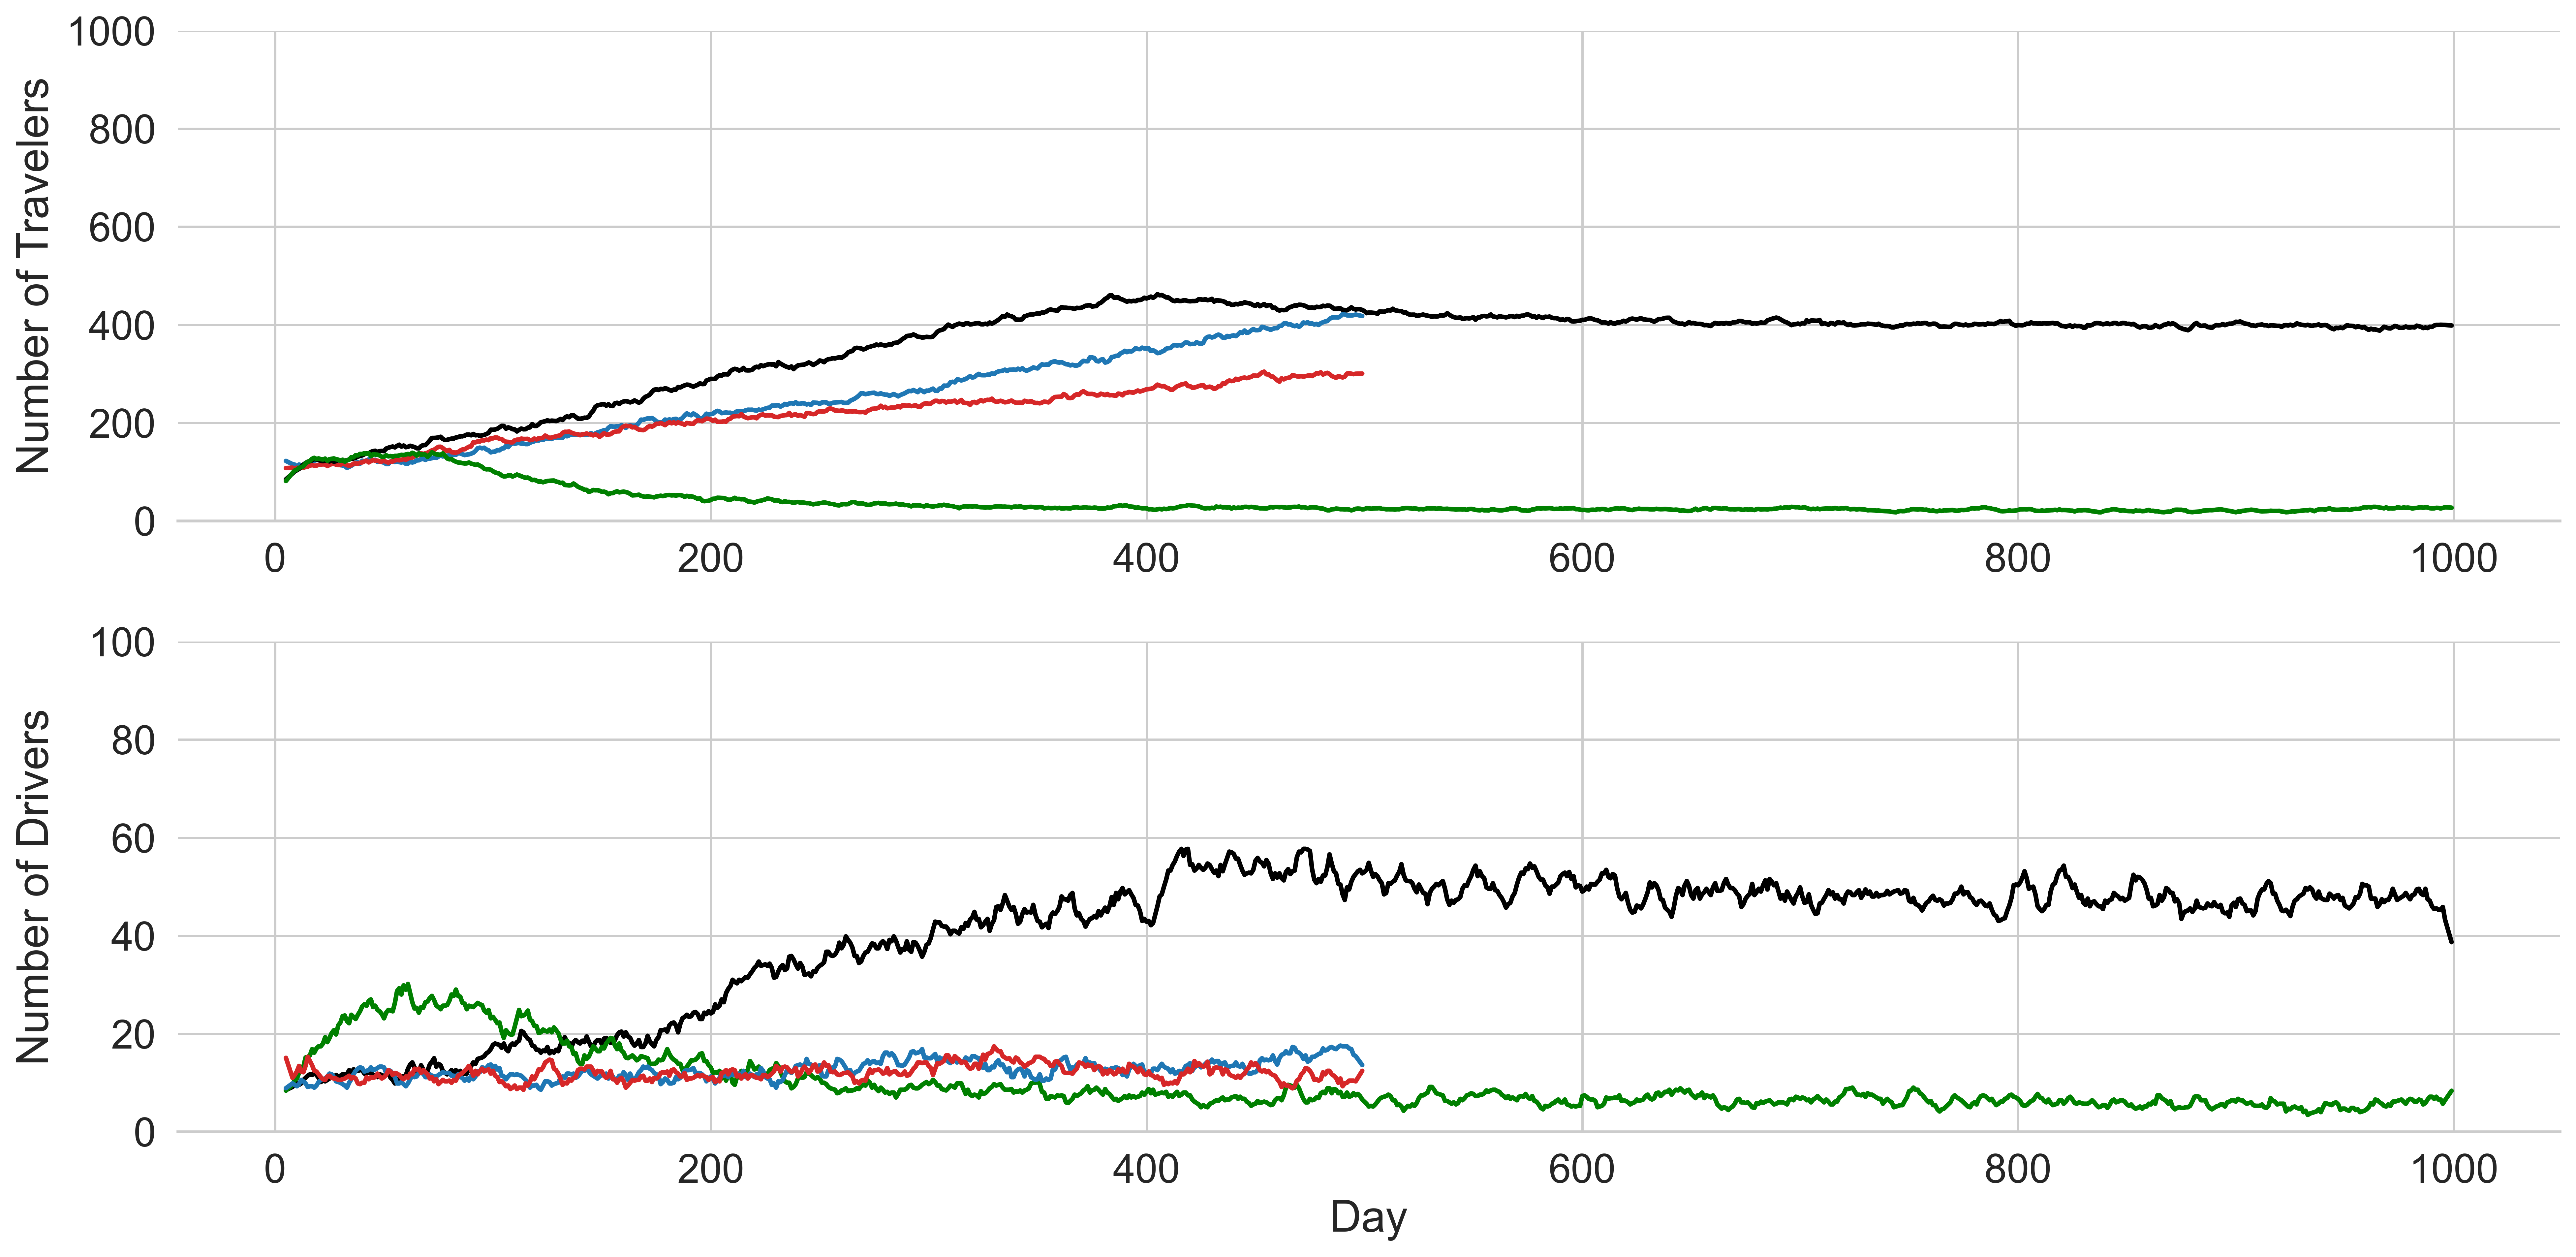

In [10]:
# dfd0 = pd.read_csv('Grid-based Competition/competition_csv/demand_traj_p1_1.0_p2_2.0.csv')
# dfs0 = pd.read_csv('Grid-based Competition/competition_csv/supply_traj_p1_1.0_p2_2.0.csv')

sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1.6)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,8))
sns.despine(left=True)

c1 = 'C0'
c2 = 'C3'

sns.lineplot(x=df_d.index, y=smooth(df_d.P1_OUT), color=c1, lw=2, ax=ax[0])
sns.lineplot(x=df_d.index, y=smooth(df_d.P2_OUT), color=c2, lw=2, ax=ax[0])
ax[0].set(xlabel='', ylabel='Number of Travelers', ylim=(0,1000))

sns.lineplot(x=dfd0.index, y=smooth(dfd0.P1_OUT), color='black', lw=2, ax=ax[0])
sns.lineplot(x=dfs0.index, y=smooth(dfs0.P1_OUT), color='black', lw=2, ax=ax[1])
sns.lineplot(x=dfd0.index, y=smooth(dfd0.P2_OUT), color='green', lw=2, ax=ax[0])
sns.lineplot(x=dfs0.index, y=smooth(dfs0.P2_OUT), color='green', lw=2, ax=ax[1])


sns.lineplot(x=df_s.index, y=smooth(df_s.P1_OUT), color=c1, lw=2, ax=ax[1])
sns.lineplot(x=df_s.index, y=smooth(df_s.P2_OUT), color=c2, lw=2, ax=ax[1])
ax[1].set(xlabel='Day', ylabel='Number of Drivers', ylim=(0,100))

# ax[0].set_xticks(np.arange(0, demand_df.index.max() + 2, 100))
# ax[1].set_xticks(np.arange(0, demand_df.index.max() + 2, 100))

fig.align_ylabels()
plt.tight_layout()
# plt.savefig('Figs/p3-Fig_10_20_ms.png')

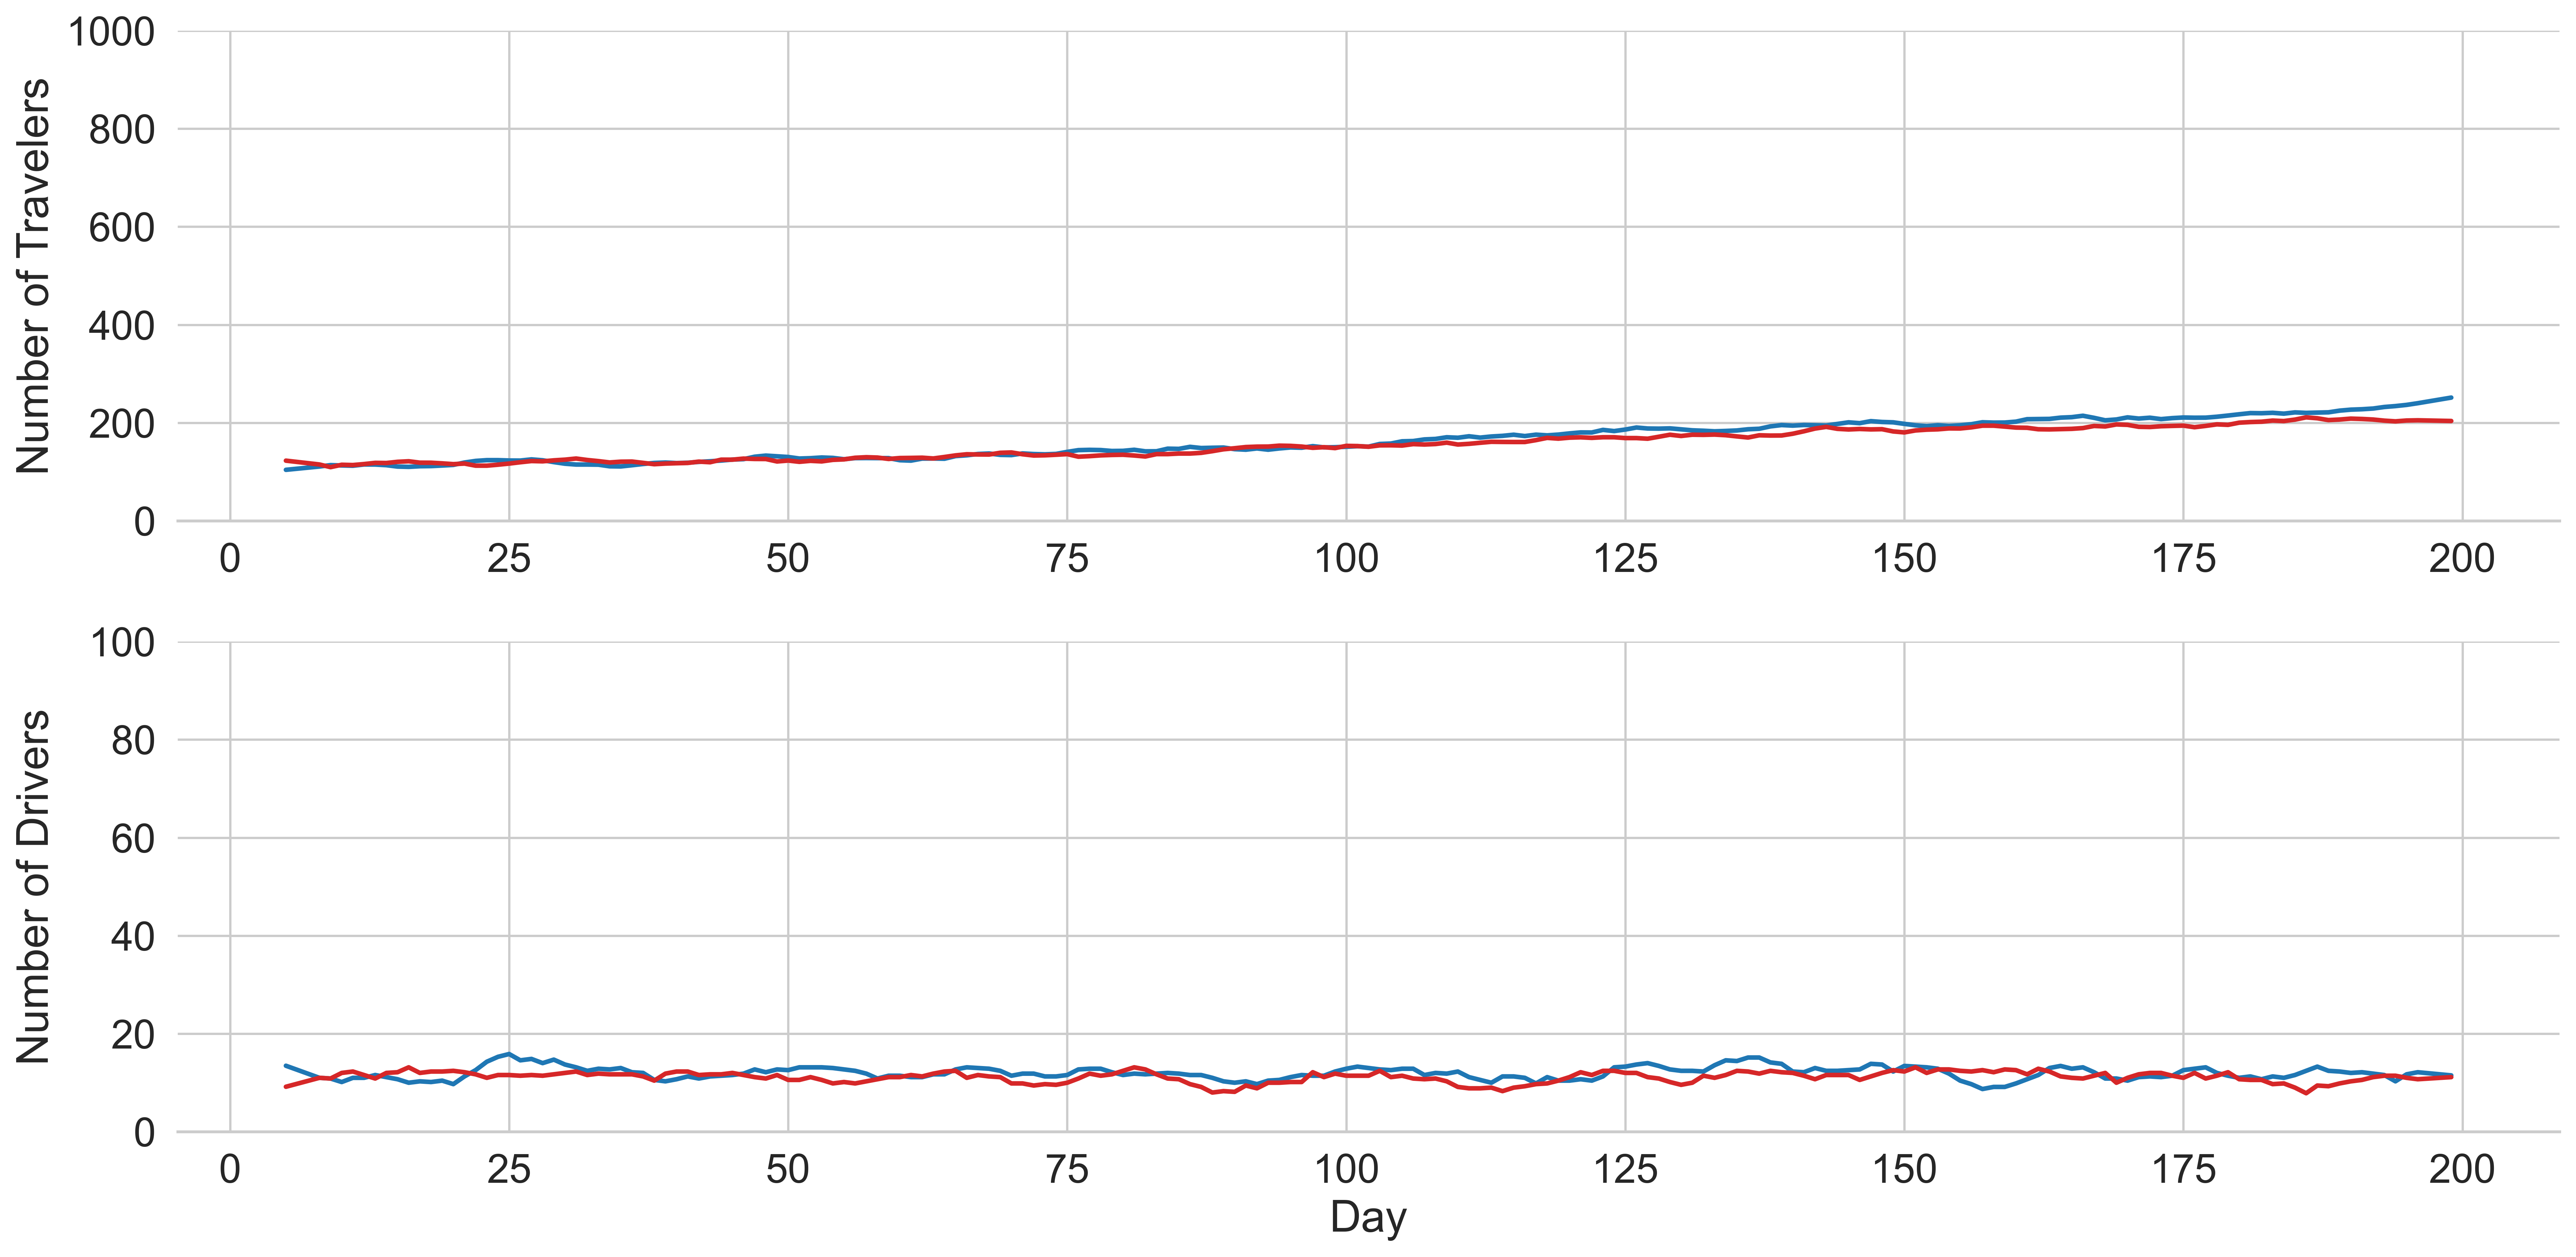

In [13]:
demand_df = pd.read_csv('demand_test.csv')
supply_df = pd.read_csv('supply_test.csv')

sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1.6)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,8))
sns.despine(left=True)

c1 = 'C0'
c2 = 'C3'

sns.lineplot(x=demand_df.index, y=smooth(demand_df.P1_OUT), color=c1, lw=2, ax=ax[0])
sns.lineplot(x=demand_df.index, y=smooth(demand_df.P2_OUT), color=c2, lw=2, ax=ax[0])
ax[0].set(xlabel='', ylabel='Number of Travelers', ylim=(0,1000))

sns.lineplot(x=supply_df.index, y=smooth(supply_df.P1_OUT), color=c1, lw=2, ax=ax[1])
sns.lineplot(x=supply_df.index, y=smooth(supply_df.P2_OUT), color=c2, lw=2, ax=ax[1])
ax[1].set(xlabel='Day', ylabel='Number of Drivers', ylim=(0,100))

# ax[0].set_xticks(np.arange(0, demand_df.index.max() + 2, 100))
# ax[1].set_xticks(np.arange(0, demand_df.index.max() + 2, 100))

fig.align_ylabels()
plt.tight_layout()
# plt.savefig('Figs/p3-Fig_10_20_ms.png')

In [11]:
sim.trajectory

{'P1': [(1.0, 0.05505811431064574, 154.25512000000006, 0.056275000000000006),
  (1.0, 0.060380114659685874, 170.68303200000003, 0.061185),
  (1.0, 0.06731799650959862, 188.21902000000003, 0.06894000000000002),
  (1.0, 0.07789398516579404, 217.77715999999992, 0.07977499999999998),
  (1.0, 0.08371126998254799, 230.45355200000006, 0.08698499999999999),
  (1.0, 0.09735074904013961, 275.3880919999999, 0.09858000000000003),
  (0.8, 0.09582326565445029, 240.2059872000001, 0.10780500000000001),
  (0.8, 0.09952813308900527, 241.89557760000008, 0.11462500000000003),
  (0.8, 0.10729959940663178, 258.2631296, 0.12445500000000001),
  (0.8, 0.12432361361256547, 309.52665600000006, 0.14061)],
 'P2': [(1.0, 0.05478759912739966, 150.92876800000002, 0.05689500000000001),
  (1.0, 0.06327369808027923, 177.67984000000004, 0.06452999999999999),
  (1.0, 0.0699329357766143, 196.92827199999996, 0.07113000000000001),
  (1.0, 0.0745242397905759, 208.96874400000002, 0.07610999999999998),
  (1.0, 0.081310141186736

In [12]:
print((1,2,3,4))

(1, 2, 3, 4)
